In [30]:
# Import libraries
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from scipy.sparse import hstack
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [93]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Spam-related keywords for custom features
spam_keywords = [
    'free', 'win', 'prize', 'urgent', 'claim', 'cash', 'offer',
    'click', 'selected', 'congratulations', 'gift', 'winner', 'limited', 'bonus'
]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91990\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
# Load dataset
df = pd.read_csv(r"C:\Users\91990\Spam_Email_Detection\data\spam.csv", encoding='latin-1')

df = df[['v1','v2']]  # Keep only relevant columns
df.columns = ['label','text']  # Rename columns
df['label'] = df['label'].map({'ham':0, 'spam':1})  # Encode labels
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


label
0    4825
1     747
Name: count, dtype: int64


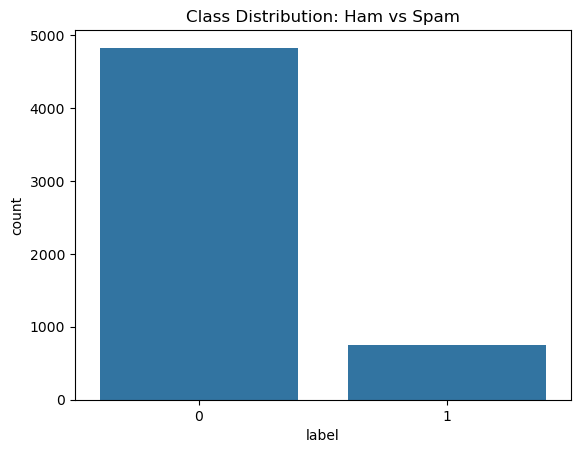

In [34]:
# Count of ham vs spam
print(df['label'].value_counts())

# Plot
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Ham vs Spam")
plt.savefig(r"C:\Users\91990\Spam_Email_Detection\reports\class_distribution.png")
plt.show()

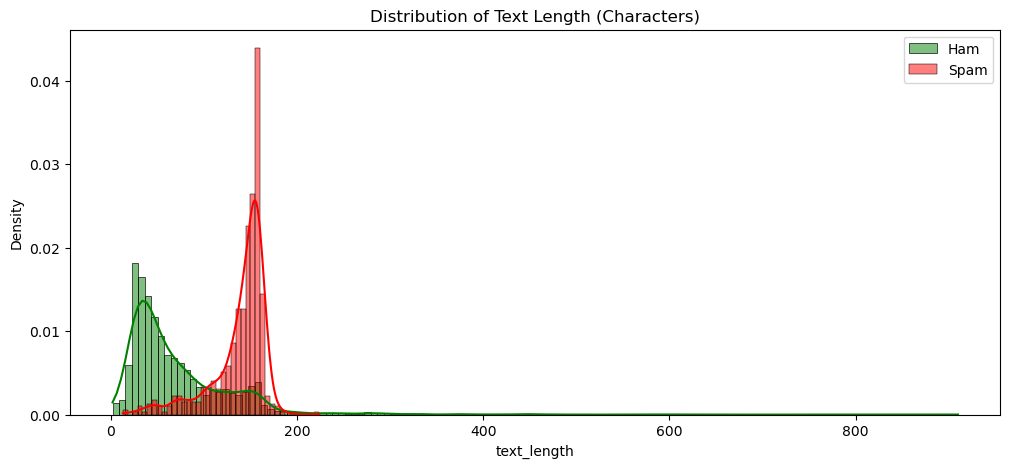

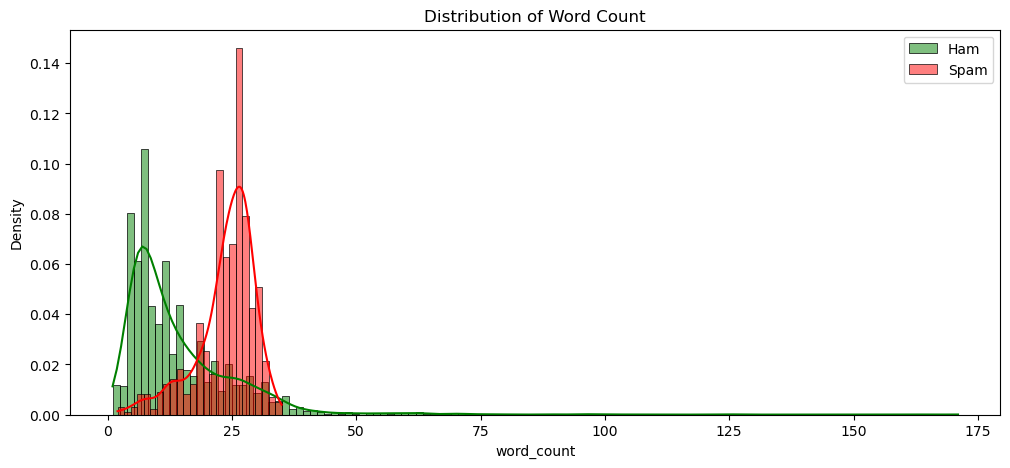

In [87]:
# If df['label'] was converted to 0/1 for modeling, make a copy for plotting
df_plot = df.copy()
df_plot['label_str'] = df_plot['label'].map({0:'ham', 1:'spam'})  # numeric → string

# Add text length and word count
df_plot['text_length'] = df_plot['text'].apply(len)
df_plot['word_count'] = df_plot['text'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(12,5))
sns.histplot(df_plot[df_plot['label_str']=='ham']['text_length'], color='green', kde=True, stat='density', label='Ham')
sns.histplot(df_plot[df_plot['label_str']=='spam']['text_length'], color='red', kde=True, stat='density', label='Spam')
plt.title("Distribution of Text Length (Characters)")
plt.savefig(r"C:\Users\91990\Spam_Email_Detection\reports\text_length_distribution.png")
plt.legend()
plt.show()

# Plot word count distribution
plt.figure(figsize=(12,5))
sns.histplot(df_plot[df_plot['label_str']=='ham']['word_count'], color='green', kde=True, stat='density', label='Ham')
sns.histplot(df_plot[df_plot['label_str']=='spam']['word_count'], color='red', kde=True, stat='density', label='Spam')
plt.title("Distribution of Word Count")
plt.savefig(r"C:\Users\91990\Spam_Email_Detection\reports\word_count_distribution.png")
plt.legend()
plt.show()

In [36]:
# Function to get top words
def get_top_words(texts, n=20):
    all_words = ' '.join(texts).lower()
    all_words = ''.join([c for c in all_words if c not in string.punctuation])
    words = [word for word in all_words.split() if word not in stop_words]
    return Counter(words).most_common(n)

print("Top words in Ham:")
print(get_top_words(df[df['label']==0]['text']))

print("\nTop words in Spam:")
print(get_top_words(df[df['label']==1]['text']))

Top words in Ham:
[('u', 972), ('im', 449), ('2', 305), ('get', 303), ('ltgt', 276), ('ok', 272), ('dont', 257), ('go', 247), ('ur', 240), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('4', 168)]

Top words in Spam:
[('call', 347), ('free', 216), ('2', 173), ('txt', 150), ('u', 147), ('ur', 144), ('mobile', 123), ('text', 120), ('4', 119), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60)]


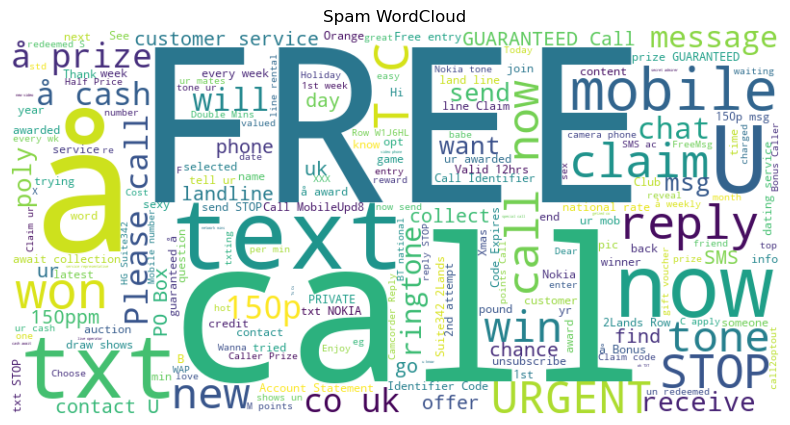

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud for spam
spam_text = ' '.join(df[df['label']=='spam']['text'])
spam_wc = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10,5))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Spam WordCloud")
spam_wc.to_file(r"C:\Users\91990\Spam_Email_Detection\reports\spam_wordcloud.png")
plt.show()

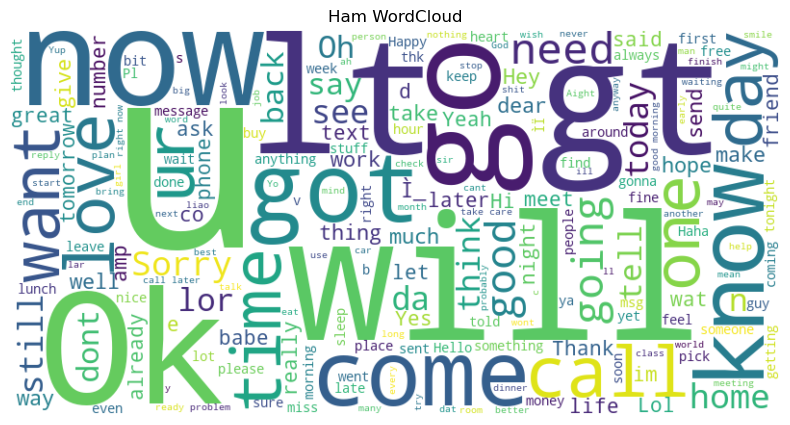

In [7]:
# WordCloud for ham
ham_text = ' '.join(df[df['label']=='ham']['text'])
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.figure(figsize=(10,5))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Ham WordCloud")
ham_wc.to_file(r"C:\Users\91990\Spam_Email_Detection\reports\ham_wordcloud.png")
plt.show()

In [38]:
# Separate ham and spam
spam_df = df[df.label==1]
ham_df = df[df.label==0]

# Upsample spam
spam_upsampled = resample(spam_df, replace=True, n_samples=len(ham_df), random_state=42)

# Combine
df_balanced = pd.concat([ham_df, spam_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['label'].value_counts()

label
0    4825
1    4825
Name: count, dtype: int64

In [39]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df_balanced['text'] = df_balanced['text'].apply(preprocess_text)
df_balanced.head()

,label,text,text_length,word_count
0,0,mm yes dear look hugging p,47,11
1,0,pls dont play others life,33,7
2,0,call ltgt min thats ok,41,9
3,0,hmm yeah grooved im looking forward pound special,83,17
4,1,latest news police station toilet stolen cops ...,70,12


In [95]:
def custom_features(text):
    num_exclamations = text.count('!')
    num_numbers = sum(c.isdigit() for c in text)
    num_keywords = sum(text.count(word) for word in spam_keywords)
    has_money_pattern = int(bool(re.search(r'\$\d+', text)))
    has_earn_sign_pattern = int(bool(re.search(r'(earn|sign up|week)', text)))
    # Always 5 features
    return [num_exclamations, num_numbers, num_keywords, has_money_pattern, has_earn_sign_pattern]

In [72]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(df_balanced['text'])

# Combine TF-IDF and custom features
X = hstack([X_tfidf, custom_feat])
y = df_balanced['label'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Initialize models
nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensemble
ensemble = VotingClassifier(
    estimators=[('Multinomial_NB', nb_model), ('Logistic_Regression', lr_model), ('Random_Forest_Classifier', rf_model)],
    voting='soft'
)

# Train
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('Multinomial_NB', MultinomialNB()),
                             ('Logistic_Regression',
                              LogisticRegression(max_iter=1000)),
                             ('Random_Forest_Classifier',
                              RandomForestClassifier(random_state=42))],
                 voting='soft')

In [74]:
y_pred = ensemble.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9927461139896373

Confusion Matrix:
 [[963  12]
 [  2 953]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       975
           1       0.99      1.00      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



In [75]:
with open(r"C:\Users\91990\Spam_Email_Detection\models\ensemble_spam_model.pkl", "wb") as f:
    pickle.dump(ensemble, f)

with open(r"C:\Users\91990\Spam_Email_Detection\models\tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [98]:
def predict_email(text):
    text_clean = preprocess_text(text)
    tfidf_vect = tfidf.transform([text_clean])
    custom_feat_vect = np.array(custom_features(text_clean)).reshape(1,-1)
    X_vect = hstack([tfidf_vect, custom_feat_vect])
    pred = ensemble.predict(X_vect)
    return "Spam" if pred[0]==1 else "Ham"

In [100]:
from scipy.sparse import hstack

def predict_email(text, model, tfidf):
    text_clean = preprocess_text(text)
    tfidf_vect = tfidf.transform([text_clean])
    custom_feat_vect = np.array(custom_features(text_clean)).reshape(1,-1)
    X_vect = hstack([tfidf_vect, custom_feat_vect])
    pred = model.predict(X_vect)
    return "Spam" if pred[0]==1 else "Ham"


In [102]:
test_emails = [
    "You won $5000! Claim your cash prize immediately.",
    "URGENT! Your account has been compromised. Verify now.",
    "Get free Viagra pills now. Limited offer!",
    "Congratulations! You are selected for a free cruise. Click here.",
    "Earn $2000/week from home! Sign up today.",
    "Hey, are we meeting for dinner tonight?"
]

for email in test_emails:
    print(email, "→", predict_email(email, ensemble, tfidf))

You won $5000! Claim your cash prize immediately. → Spam
URGENT! Your account has been compromised. Verify now. → Spam
Get free Viagra pills now. Limited offer! → Spam
Congratulations! You are selected for a free cruise. Click here. → Spam
Earn $2000/week from home! Sign up today. → Spam
Hey, are we meeting for dinner tonight? → Ham


In [104]:
test_emails = [
    "You won $5000! Claim your cash prize immediately.",
    "URGENT! Your account has been compromised. Verify now.",
    "Get free Viagra pills now. Limited offer!",
    "Congratulations! You are selected for a free cruise. Click here.",
    "Earn $2000/week from home! Sign up today.",
    "Hey, are we meeting for dinner tonight?",
    "Happy birthday! Wishing you all the best.",
    "Earn $5000/week working from home. Limited spots available!",
    "Don’t forget to submit the report by 5 PM."
]

for email in test_emails:
    print(email, "→", predict_email(email, ensemble, tfidf))

You won $5000! Claim your cash prize immediately. → Spam
URGENT! Your account has been compromised. Verify now. → Spam
Get free Viagra pills now. Limited offer! → Spam
Congratulations! You are selected for a free cruise. Click here. → Spam
Earn $2000/week from home! Sign up today. → Spam
Hey, are we meeting for dinner tonight? → Ham
Happy birthday! Wishing you all the best. → Ham
Earn $5000/week working from home. Limited spots available! → Spam
Don’t forget to submit the report by 5 PM. → Ham
